**Import Libraries**

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
from scipy.spatial import voronoi_plot_2d, Voronoi
from matplotlib.patches import Patch
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

**Define Clustering Evaluation Function**

In [104]:
def evaluate_clustering(X, labels, n_clusters, ax=None, title_suffix = ''):
    """
    Evaluate a clustering model using silhouette scores and the Davies-Bouldin index.
    
    Parameters:
    X (ndarray): Feature matrix.
    labels (array-like): Cluster labels assigned to each sample.
    n_clusters (int): The number of clusters in the model.
    ax: The subplot axes to plot on.
    title_suffix (str): Optional suffix for plot titlec
    
    Returns:
    None: Displays silhoutte scores and a silhouette plot.
    """
    if ax is None:
        ax = plt.gca() # Get the current axis if none is provided
    
    # Calculate silhouette scores
    silhouette_avg = silhouette_score(X, labels)
    sample_silhouette_values = silhouette_samples(X, labels)

    # Plot silhouette analysis on the provided axis
    unique_labels = np.unique(labels)
    colormap = cm.tab10
    color_dict = {label: colormap(float(label)/n_clusters) for label in unique_labels}
    y_lower = 10
    for i in unique_labels:
        ith_cluster_silhouette_values = sample_silhouette_values[labels==i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower+size_cluster_i
        color = color_dict[i]

        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower+0.5*size_cluster_i, str(i))
        y_lower = y_upper+10
    
    ax.set_title(f'Silhouette Score for {title_suffix} \n' + 
                 f'Average Silhouette: {silhouette_avg:.2f}')
    ax.set_xlabel('Silhouette Coefficient')
    ax.set_ylabel('Cluster')
    ax.axvline(x=silhouette_avg, color='red', linestyle='--')
    ax.set_xlim([-0.25, 1])  # Set the x-axis range to [0, 1]
    ax.set_yticks([])

**Create synthetic data with four blobs to experiment with k-means clustering**

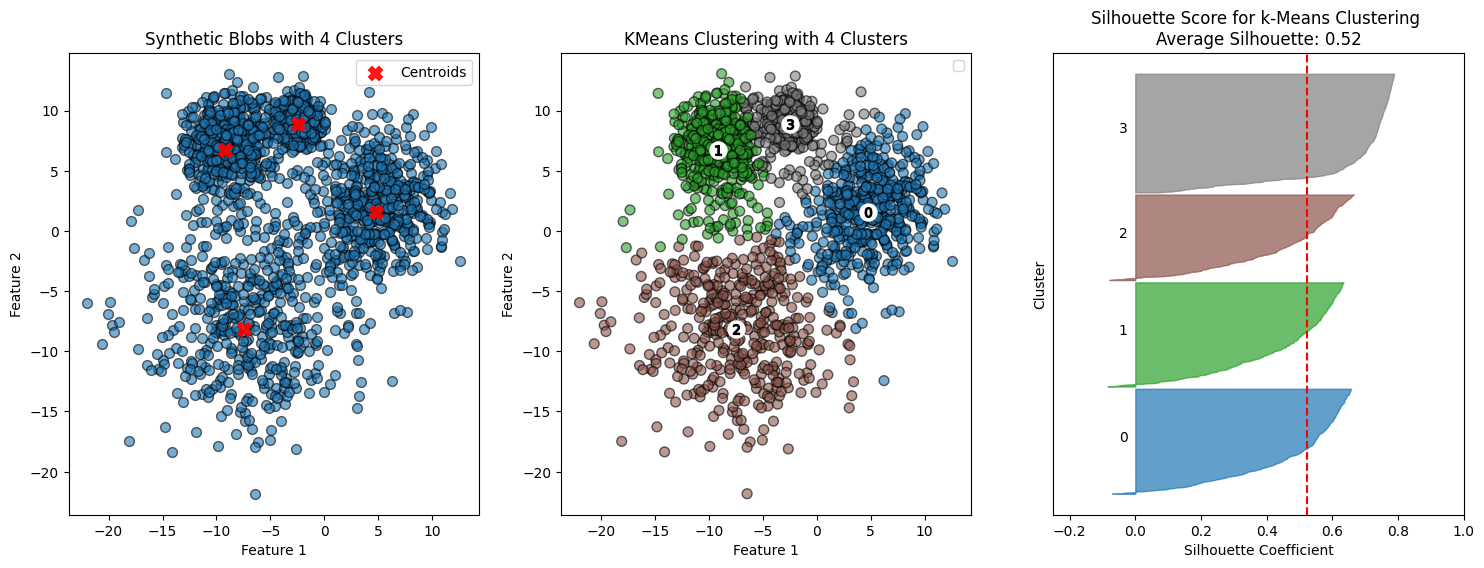

In [136]:
X, y = make_blobs(n_samples=2000, centers=4, n_features=2, cluster_std=[1.0, 3, 5, 2], random_state=42)

# Apply KMeans clustering
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=12, random_state=42)
kmeans.fit(X)
y_kmeans = kmeans.fit_predict(X)

colormap = cm.tab10
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.scatter(X[:, 0], X[:, 1], s=50, edgecolors='k', alpha=0.6)
cluster_centers = kmeans.cluster_centers_
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', s=100, marker='X', alpha=0.9, label='Centroids')

plt.title(f'Synthetic Blobs with {n_clusters} Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

colors = colormap(y_kmeans.astype(float)/n_clusters)
plt.subplot(1, 3, 2)
plt.scatter(X[:, 0], X[:, 1], c=colors, s=50, alpha=0.6, edgecolor='k')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='o', s=150, color='white', alpha=1)

# Label the custer number
for i, c in enumerate(cluster_centers):
    plt.scatter(c[0], c[1], marker='$%d$'%i, alpha=1, s=50, edgecolors='k')

plt.title(f'KMeans Clustering with {n_clusters} Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Evaluate the clustering
plt.subplot(1, 3, 3)
evaluate_clustering(X=X, labels=y_kmeans, n_clusters=n_clusters, title_suffix='k-Means Clustering')

**Lets check how `inertia` changes wrt `random_state`**

Lets run the model `n` number of times

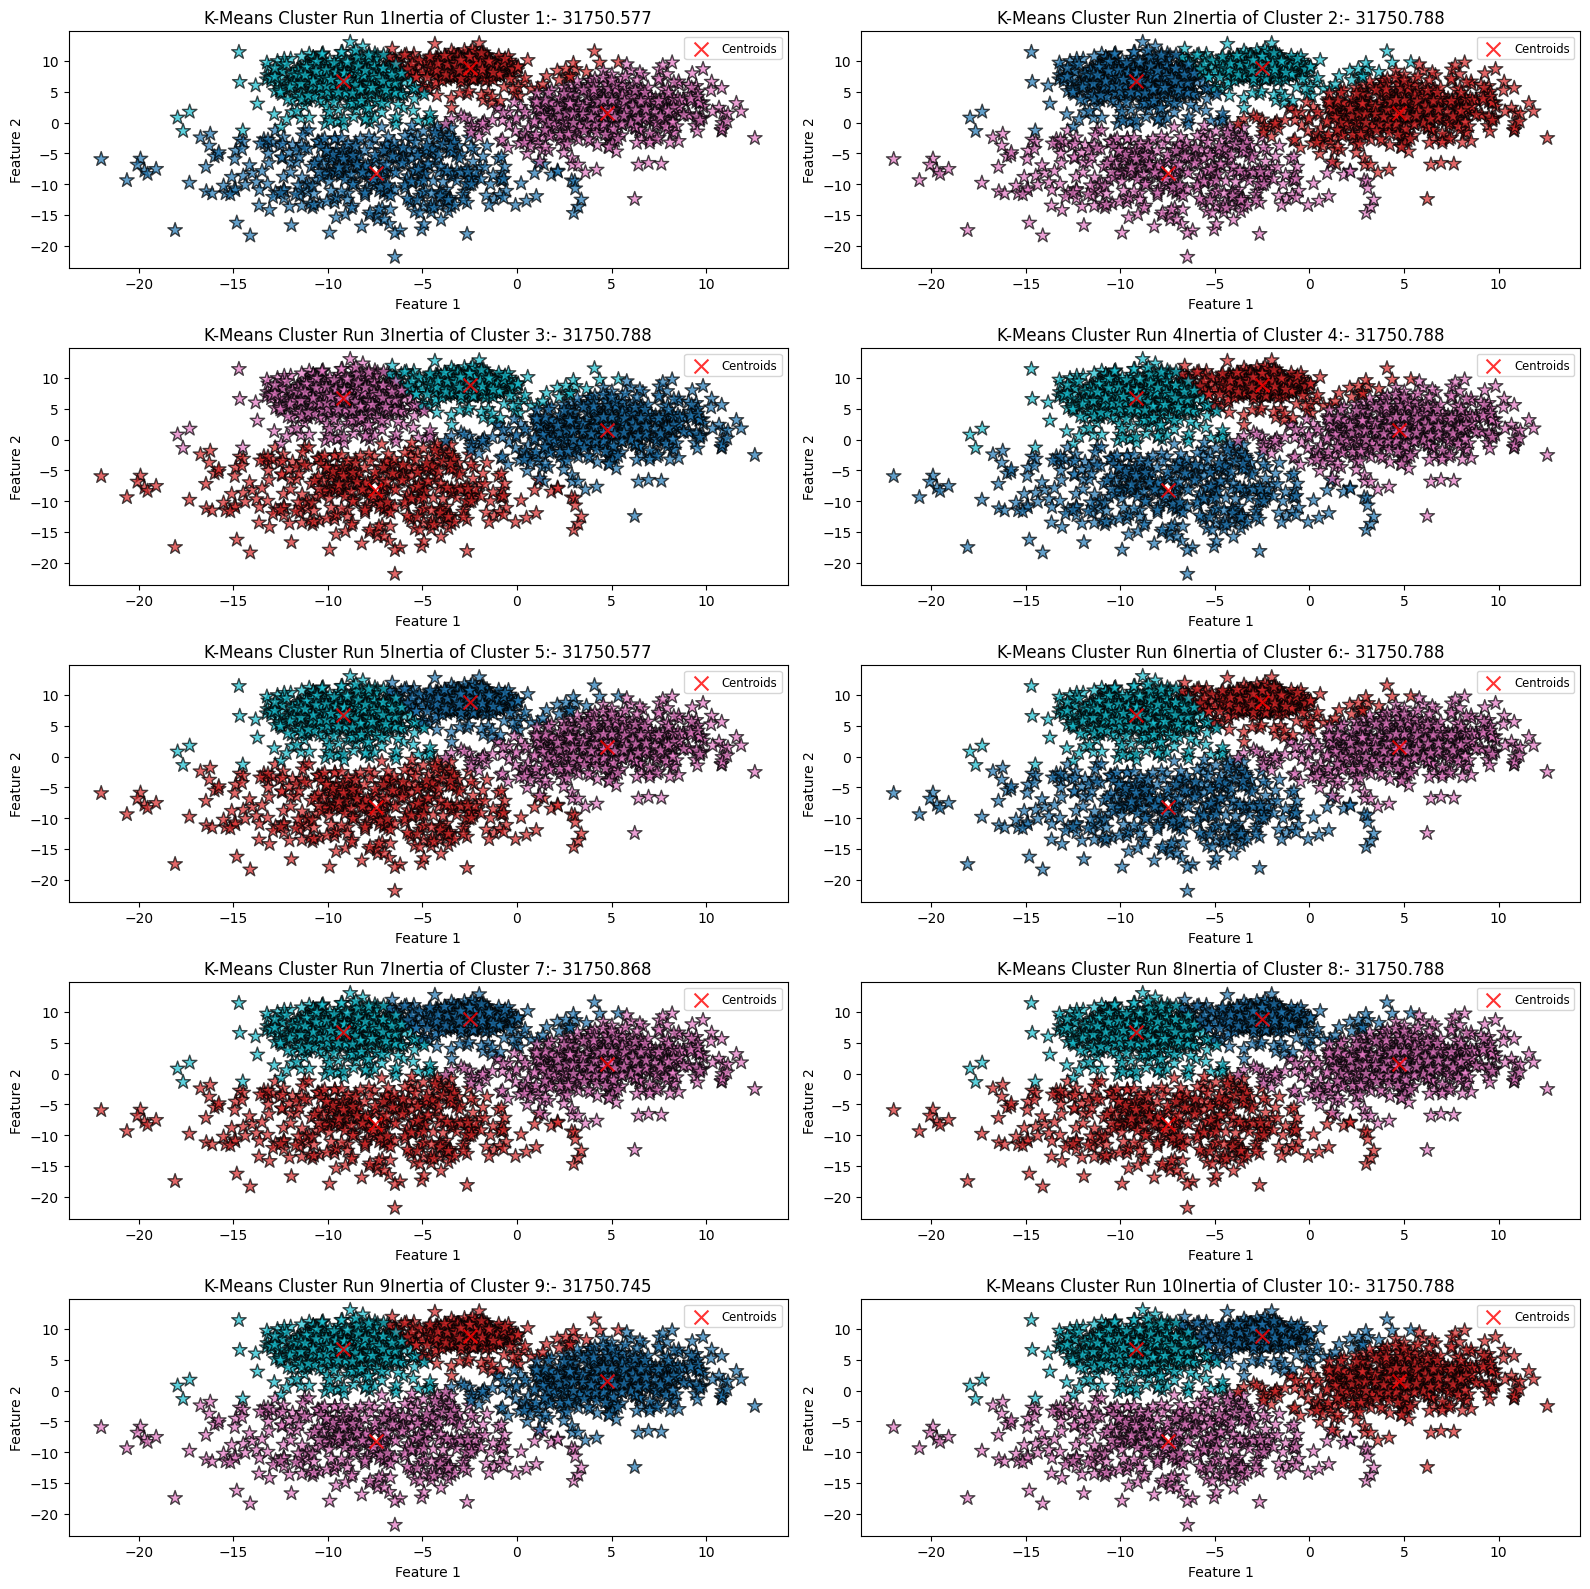

Inertia value for cluster 1: 31750.577
Inertia value for cluster 2: 31750.788
Inertia value for cluster 3: 31750.788
Inertia value for cluster 4: 31750.788
Inertia value for cluster 5: 31750.577
Inertia value for cluster 6: 31750.788
Inertia value for cluster 7: 31750.868
Inertia value for cluster 8: 31750.788
Inertia value for cluster 9: 31750.745
Inertia value for cluster 10: 31750.788


In [137]:
def n_runs(n, cluster):
    n_run = n
    n_inertia = []

    # Define row and column for plots
    n_cols = 2
    n_rows = -(-n_run//n_cols) # Python trick for ceiling division
    plt.figure(figsize=(16, 16))

    for i in range(n_run):
        k_means = KMeans(n_clusters=cluster, init='k-means++', n_init=10, random_state=None)
        k_means.fit(X)
        y_kmeans = k_means.labels_
        centers = k_means.cluster_centers_
        inertia = k_means.inertia_
        n_inertia.append(inertia)

        plt.subplot(n_rows, n_cols, i+1)
        plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, cmap='tab10', marker='*', s=120, edgecolors='k', alpha=0.7)
        plt.scatter(centers[:, 0], centers[:, 1], marker='x', color='red', s=100, alpha=0.8, label='Centroids')
        plt.title(f'K-Means Cluster Run {i+1}'+
                  f'Inertia of Cluster {i+1}:- {inertia:.3f}')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.legend(loc='upper right', fontsize='small')
        plt.tight_layout()
    plt.show()
    
    for j, inert in enumerate(n_inertia, 1):
        print(f'Inertia value for cluster {j}: {inert:.3f}')

n_runs(10, 4)

**Now lets check with varying number of centers i.e Varying Clusters**

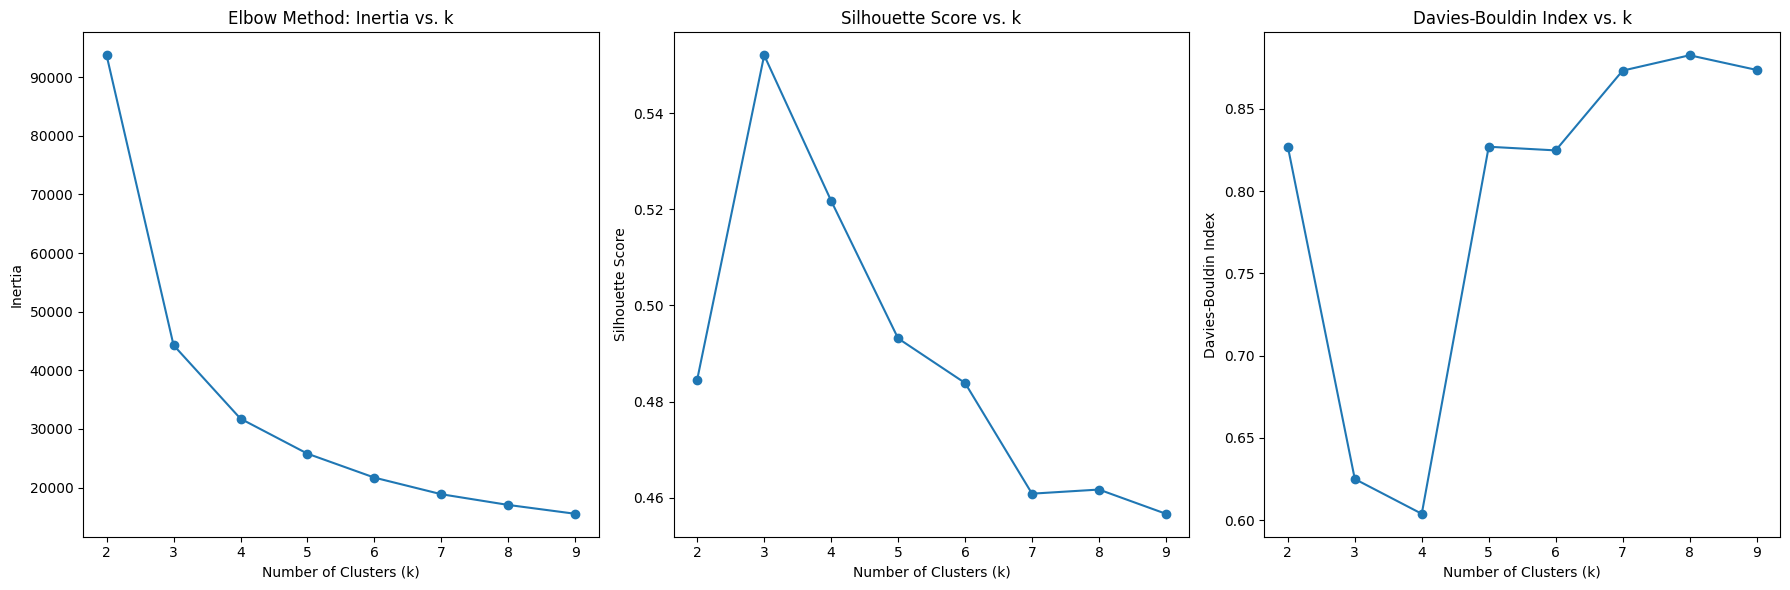

In [138]:
def k_values(n):
    cluster = range(2, n) # Minimum clusters are 2
    inertia_ = []
    silhoutte_score_ = []
    davies_bouldin_score_ = []
    labels_ = []
    centers_ = []

    for i in cluster:
        k_means = KMeans(n_clusters=i, init='k-means++', n_init=12, random_state=42)
        k_means.fit(X)
        labels_.append(k_means.labels_)
        centers_.append(k_means.cluster_centers_)
        inertia_.append(k_means.inertia_)
        silhoutte_score_.append(silhouette_score(X, k_means.labels_))
        davies_bouldin_score_.append(davies_bouldin_score(X, k_means.labels_))
    
    # Plot Inertia
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.plot(cluster, inertia_, marker='o')
    plt.title('Elbow Method: Inertia vs. k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')

    # Plot Silhoutte Score
    plt.subplot(1, 3, 2)
    plt.plot(cluster, silhoutte_score_, marker='o')
    plt.title('Silhouette Score vs. k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')

    #Plot Davies Bouldin Score
    plt.subplot(1, 3, 3)
    plt.plot(cluster, davies_bouldin_score_, marker='o')
    plt.title('Davies-Bouldin Index vs. k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Davies-Bouldin Index')

    plt.tight_layout()
    plt.show()

k_values(10)

**Result of observation**

The first plot is often used in the 'elbow method,' where the ideal value of k is chosen near the point where the curve starts to level off. Since inertia decreases as the number of clusters increases, it’s important to find the balance where adding more clusters provides diminishing returns in reducing inertia.
The inertia plot points to an optimal cluster number around 3 or 4. The silhouette score shows a clear peak at k = 3, while the Davies-Bouldin index reaches its lowest values between k = 3 and k = 4.

Overall, these metrics suggest that three clusters may be optimal, although we know that the true number of clusters in this case is actually four.

**Plot the blobs and the clustering results for k = 3, 4, and 5**

For Clusters: 3
Accurate Prediction: 51 
Accuracy Score: 2.550%

For Clusters: 4
Accurate Prediction: 450 
Accuracy Score: 22.500%

For Clusters: 5
Accurate Prediction: 999 
Accuracy Score: 49.950%



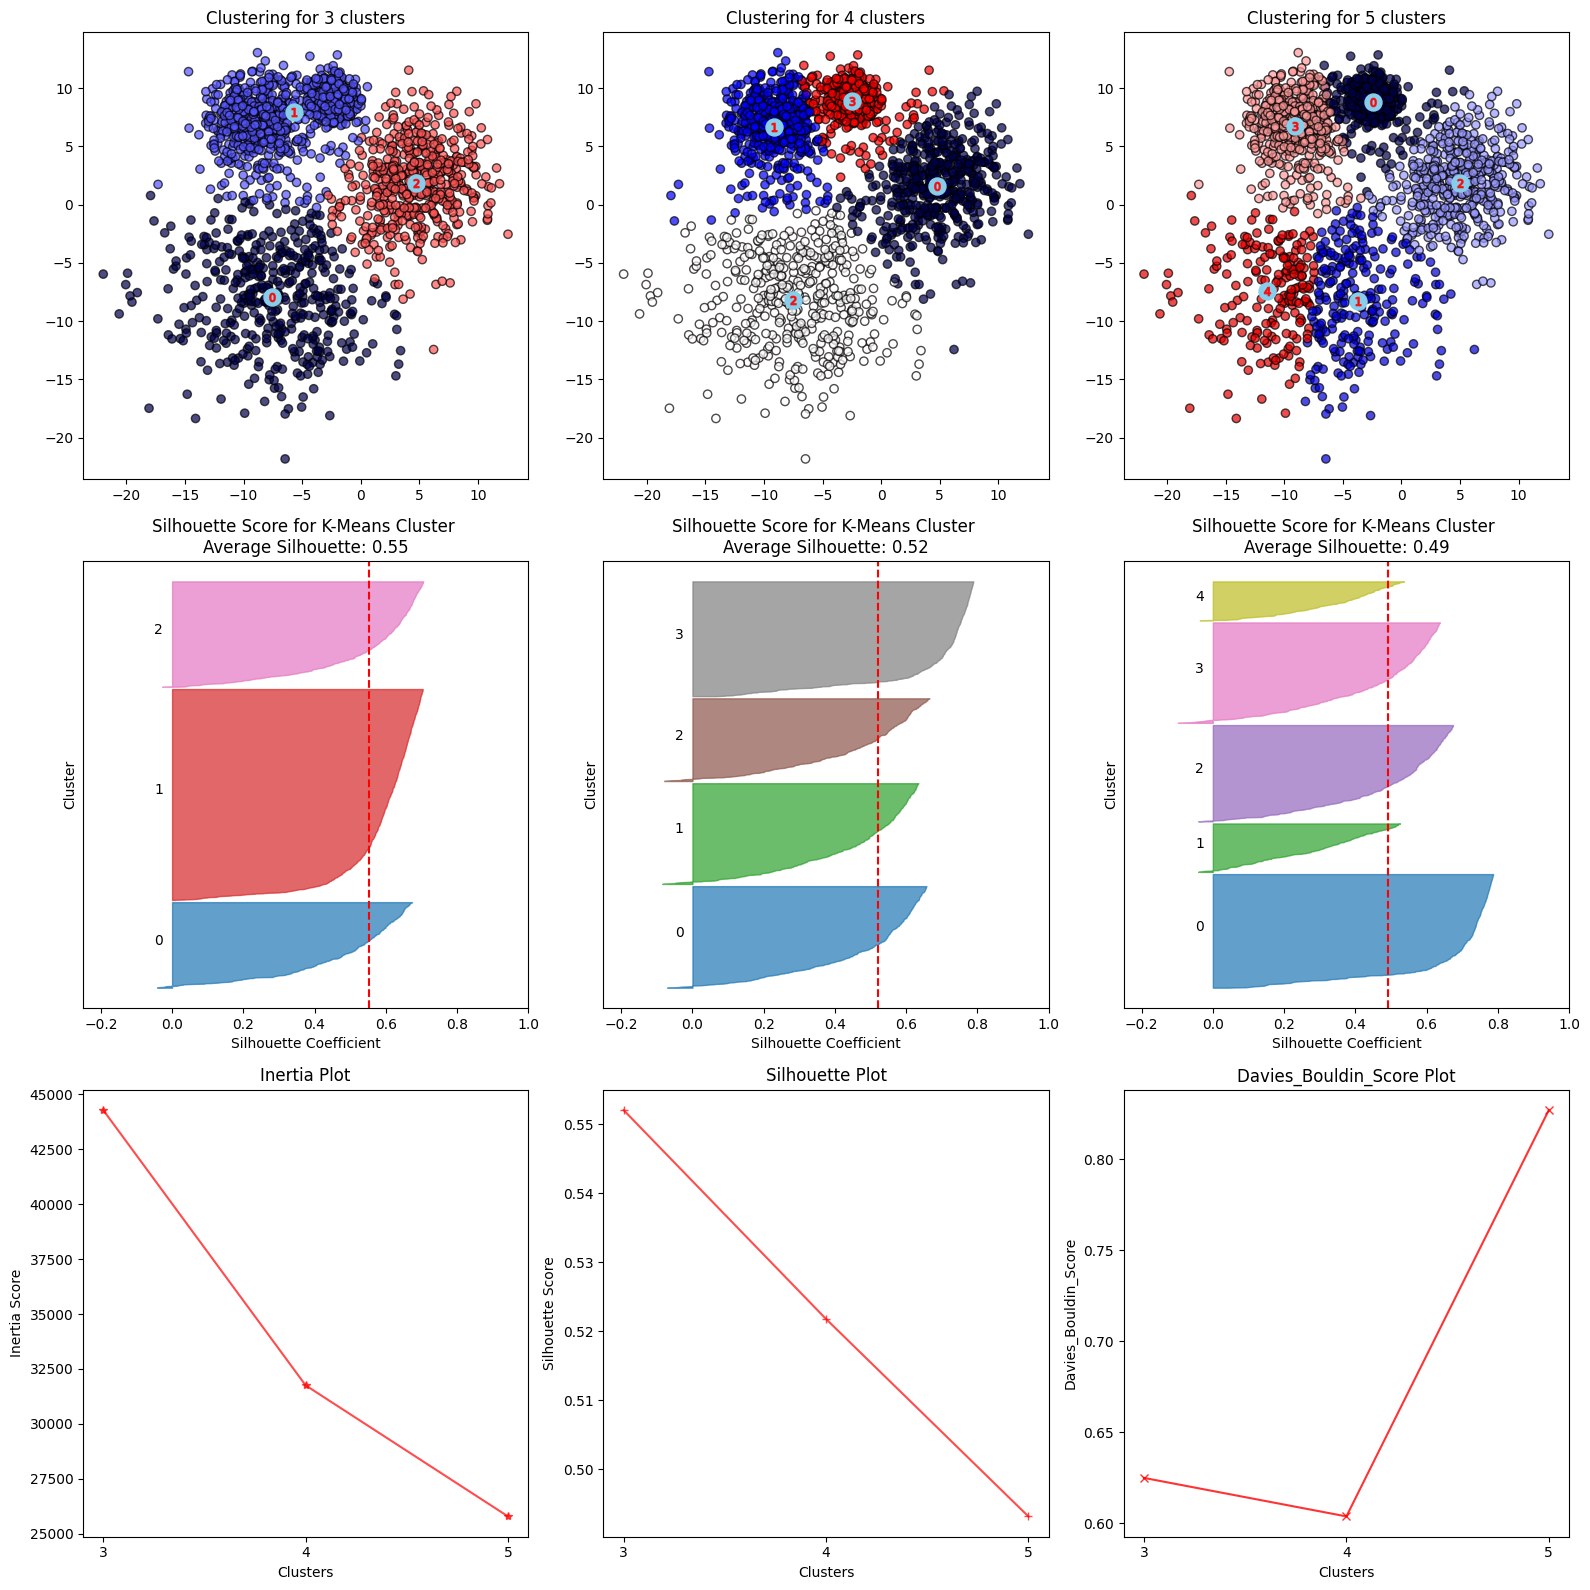

In [145]:
def fixed_clusters():
    clusters = [3, 4, 5]
    inertia_ = []
    silhoutte_score_ = []
    davies_score_ = []
    plt.figure(figsize=(16, 16))
    color_map = cm.seismic
    for i, j in enumerate(clusters):
        model = KMeans(n_clusters=j, init='k-means++', n_init=12, random_state=42)
        model.fit(X)
        labels = model.fit_predict(X)
        centers = model.cluster_centers_
        inertia_.append(model.inertia_)
        silhoutte_score_.append(silhouette_score(X, labels))
        davies_score_.append(davies_bouldin_score(X, labels))
        color = color_map(labels.astype(float)/j)
        plot1 = plt.subplot(3, 3, i+1)
        plot1.scatter(X[:, 0], X[:, 1], c=color, ec='k', alpha=0.7)
        plot1.scatter(centers[:, 0], centers[:, 1], marker='o', color='skyblue', s=150, alpha=1)

        for idx, cent in enumerate(centers):
            plt.scatter(cent[0], cent[1], marker=f'${idx}$', color='red', alpha=0.8)
        plt.title(f'Clustering for {j} clusters')

        plot2 = plt.subplot(3, 3, i+4)
        evaluate_clustering(X=X, labels=labels, n_clusters=j, title_suffix='K-Means Cluster')

        # Check approximate accuracy
        def accuracy_check():
            accurate_labels = np.sum(labels==y)
            accuracy = (accurate_labels/len(y))*100
            print(f'For Clusters: {j}')
            print(f'Accurate Prediction: {accurate_labels} \nAccuracy Score: {accuracy:.3f}%\n')
        accuracy_check()

    plt.subplot(3, 3, 7)
    plt.plot(clusters, inertia_, marker='*', color='red', alpha=0.7)
    plt.title('Inertia Plot')
    plt.xlabel('Clusters')
    plt.ylabel('Inertia Score')
    plt.xticks(clusters)
    plt.subplot(3, 3, 8)
    plt.plot(clusters, silhoutte_score_, marker='+', color='red', alpha=0.7)
    plt.title('Silhouette Plot')
    plt.xlabel('Clusters')
    plt.xticks(clusters)
    plt.ylabel('Silhouette Score')
    plt.subplot(3, 3, 9)
    plt.plot(clusters, davies_score_, marker='x', color='red', alpha=0.8)
    plt.title('Davies_Bouldin_Score Plot')
    plt.xlabel('Clusters')
    plt.ylabel('Davies_Bouldin_Score')
    plt.xticks(clusters)
    plt.tight_layout()

fixed_clusters()



### Limitations of k-means - Shape sensitivity
Can you identify situations where K-means would not be appropriate? What alternatives could be used?

Let's explore these questions with an experiment. Using `make_classification` we'll create a labelled, 2-d dataset cosisting of three classes. This time we'll have differently shaped sets of points in each class, not just spherical blobs.


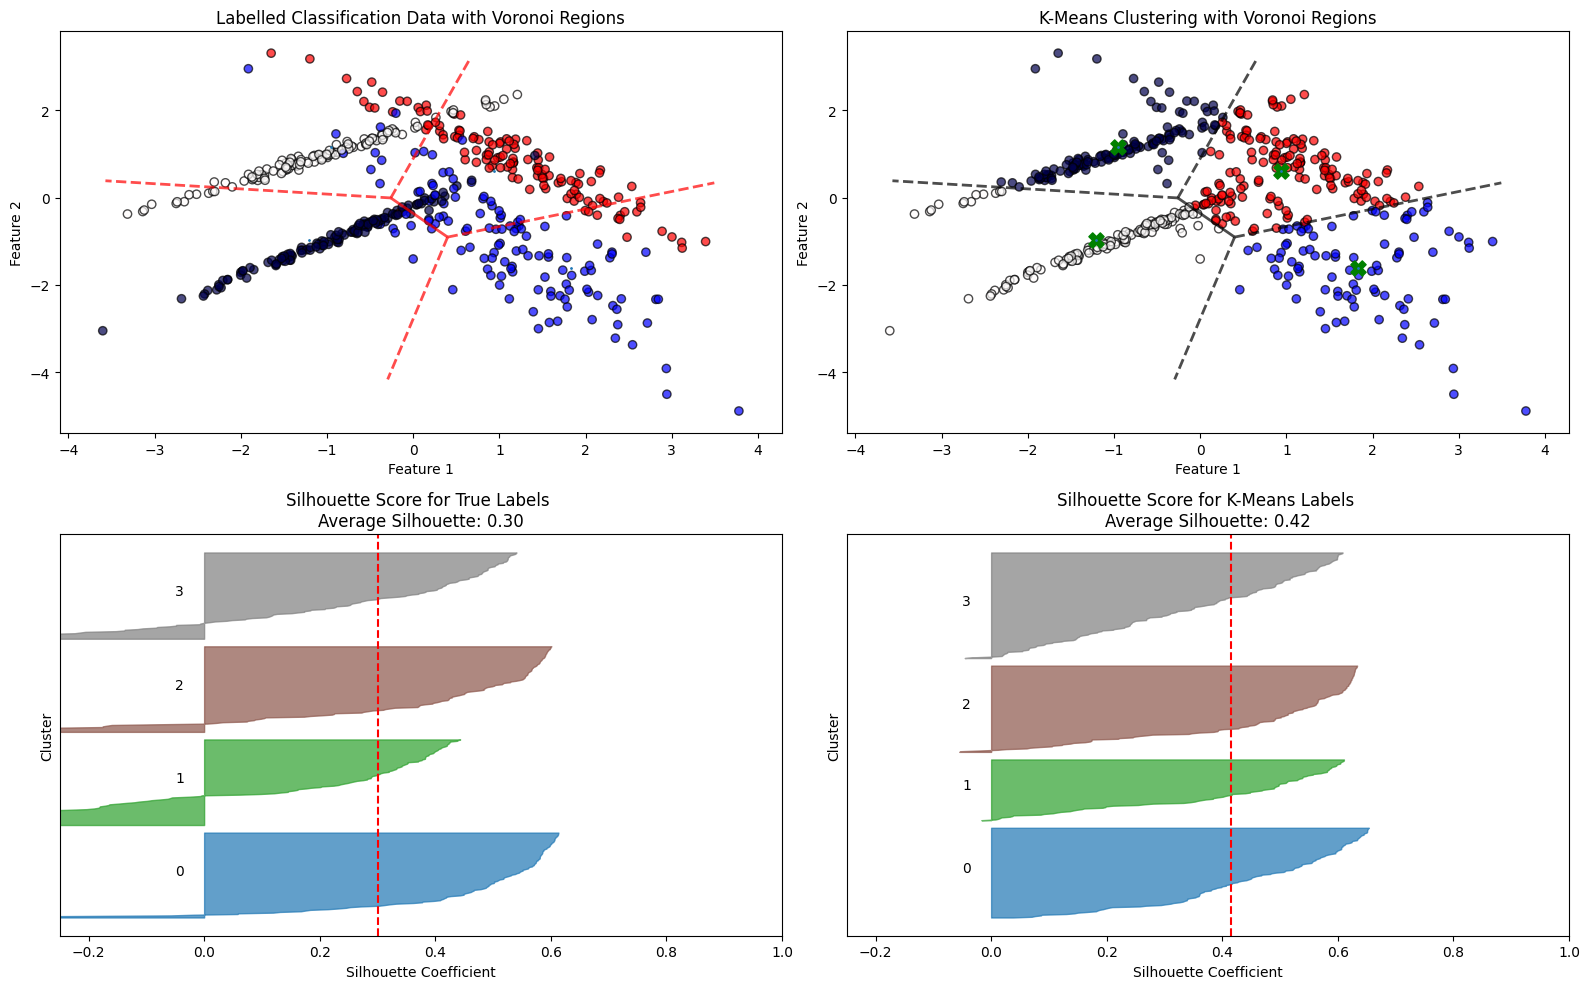

In [218]:
# Generate synthetic classification data
X_v, y_v = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, n_classes=4, random_state=42)

# Apply K-Means clustering
clusters = 4
model = KMeans(n_clusters=clusters, init='k-means++', n_init=12, random_state=42)
model.fit(X_v)
label_ = model.fit_predict(X_v)
center_ = model.cluster_centers_

# Compute the Voronoi diagram
vor = Voronoi(center_)

# Create a 2x2 grid of subplots
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

# Get consistent axis limits for all scatter plots
X_min, X_max = X_v[:, 0].min()-0.5, X_v[:, 0].max()+0.5
y_min, y_max = X_v[:, 1].min()-0.5, X_v[:, 1].max()+0.5

# Plot the actual labels (y_v) with Voronoi regions
color_map = cm.seismic
color = color_map(y_v.astype(float)/clusters)
ax[0, 0].scatter(X_v[:, 0], X_v[:, 1], c=color, ec='k', alpha=0.7)
voronoi_plot_2d(vor=vor, ax=ax[0, 0], show_vertices=False, line_colors='r', line_width=2, line_alpha=0.7, point_size=2, show_points = True)
ax[0, 0].set_title('Labelled Classification Data with Voronoi Regions')
ax[0, 0].set_xlabel('Feature 1')
ax[0, 0].set_ylabel('Feature 2')
ax[0, 0].set_xlim(X_min, X_max)
ax[0, 0].set_ylim(y_min, y_max)

# Call evaluate_clustering for true labels
evaluate_clustering(X = X_v, labels=y_v, ax=ax[1, 0], title_suffix='True Labels', n_clusters=clusters)

# Plot K-Means clustering results with Voronoi regions
color_ = color_map(label_.astype(float)/clusters)
ax[0, 1].scatter(X_v[:, 0], X_v[:, 1], c=color_, ec='k', alpha=0.7)
ax[0, 1].scatter(center_[:, 0], center_[:, 1], marker='X', color='green', s=120, alpha=1)
voronoi_plot_2d(vor=vor, ax=ax[0, 1], show_points = True, show_vertices=False, line_color='red', line_width=2, line_alpha=0.7, point_size=2)
ax[0, 1].set_title('K-Means Clustering with Voronoi Regions')
ax[0, 1].set_xlabel('Feature 1')
ax[0, 1].set_ylabel('Feature 2')
ax[0, 1].set_xlim(X_min, X_max)
ax[0, 1].set_ylim(y_min, y_max)

# Call evaluate_clustering for K-Means labels
evaluate_clustering(X=X_v, labels=label_, n_clusters=clusters, ax=ax[1, 1], title_suffix='K-Means Labels')

plt.tight_layout()
plt.show()


	•	n_samples=2000: Generate 2000 total data points (rows).
	•	n_features=2: Each data point has 2 features (columns).
	•	n_informative=2: All 2 features are informative (used to separate the classes).
	•	n_redundant=0: No redundant features (features derived from informative ones).
	•	n_clusters_per_class=1: Each class is made up of 2 subclusters (adds complexity to the dataset).
	•	n_classes=3: There are 3 output classes (i.e., target labels: 0, 1, and 2).
	•	random_state=42: For reproducibility (same results every time you run it).